In [92]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from collections import Counter
import os

In [93]:
script_dir = os.path.dirname(os.path.abspath(''))
train_mask_path = os.path.join(script_dir, "Assignment_1/Data/Train/masks/");
train_tissue_path = os.path.join(script_dir, "Assignment_1/Data/Train/Tissue/");
test_tissue_path = os.path.join(script_dir, "Assignment_1/Data/Test/Tissue/");
test_mask_path = os.path.join(script_dir, "Assignment_1/Data/Test/Mask/");

output_path = os.path.join(script_dir, "Assignment_1/Output/");

In [94]:
def createImage(shape):
    img = np.full((shape[0], shape[1]),0,dtype='uint8')
    print(img.shape)
    return img

def create3ChImage(shape):
    img = np.full((shape[0],shape[1],3),0,dtype='uint8')
    return img

def showImage(image):
    image = np.copy(image)
    print(image.shape)
    # cv.imshow('myImage', image)
    # cv.waitKey()
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    return

def monoTone(image):
    image = np.copy(image)
    ret,thresh = cv.threshold(image,np.mean(image),255,0);
    return thresh;

def createBorders(image,border_size):
    padded = np.pad(image,pad_width=border_size)
    #print(padded.shape)
    return padded

def createBordersWhite(image,border_size):
    padded = np.pad(image,pad_width=border_size,mode="constant",constant_values = 255)
    return padded

def pad_image(image, pad_height, pad_width):
    height, width, channels = image.shape
    padded_image = np.zeros((height + 2 * pad_height, width + 2 * pad_width, channels), dtype=np.uint8)
    padded_image[pad_height:pad_height+height, pad_width:pad_width+width, :] = image
    return padded_image

def remove_border(image, border_size):
    image = np.copy(image)
    height, width = image.shape[:2] 
    cropped_image = image[border_size:height-border_size, border_size:width-border_size]
    return cropped_image


In [95]:
def find_neighbors_labels(i,j,labelmatrix):
    neighbors_labels = []
    
    if(i > 0 and j < (labelmatrix.shape[1]-1)):
        #print(labelmatrix[i-1,j+1])
        if(labelmatrix[i-1,j+1] != 0):
            neighbors_labels.append(labelmatrix[i-1,j+1])
    if(i>0):
        if(labelmatrix[i-1,j]!=0):
            neighbors_labels.append(labelmatrix[i-1,j])
    if((i > 0 and j > 0)):
        if(labelmatrix[i-1,j-1]) != 0:
            neighbors_labels.append(labelmatrix[i-1,j-1])
    if(j>0):
        if(labelmatrix[i,j-1] != 0):
            neighbors_labels.append(labelmatrix[i,j-1])

    return neighbors_labels

In [96]:
def cca(image, way, v_set):
    labelmatrix = np.zeros(image.shape)
    label = 0;
    eq_list = OrderedDict()
    v = {}
    for z in v_set:
        v[z] =0
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            if (image[i,j] in v):
                neighbors_labels = find_neighbors_labels(i,j,labelmatrix)
                if(len(neighbors_labels)>0):
                    if(neighbors_labels.count(neighbors_labels[0]) == len(neighbors_labels)):
                        labelmatrix[i,j] = neighbors_labels[0]
                    else:
                        labelmatrix[i,j] = min(neighbors_labels)
                        to_replace = []
                        for x in neighbors_labels:
                            if x != labelmatrix[i][j]:
                                to_replace.append(x)
                                labelmatrix[labelmatrix == x] = labelmatrix[i,j]
                                if x in eq_list and labelmatrix[i,j] in eq_list:
                                    eq_list[labelmatrix[i,j]].append(x)
                                    eq_list.pop(x)
                else:
                    label += 1; 
                    labelmatrix[i,j] = label;
                    eq_list[label] = []
    
    return labelmatrix,len(eq_list)

In [97]:
def calculateHistogram(image):
    max = np.max(image)
    print(max);
    data = np.zeros(int(np.max(image))+1);
    for x in image: 
        for y in x:
            data[int(y)] += 1;

    width = 0.8
    labels = np.arange(int(np.max(image)+1))
    print(data)
    plt.figure(figsize=(10,3))
    plt.bar(labels,data, width)
    plt.show();

In [98]:
def remove_background(image, segmented_image, label):
    image = np.copy(image)
    for x in range(segmented_image.shape[0]):
        for y in range(segmented_image.shape[1]):
            y = int(y)
            if segmented_image[x,y] == label:
                image[x,y] = 0
    return image


def shade_layer(image, segmented_image, label,gray_value):
    image = np.zeros(image.shape).astype('uint8')
    image = createBorders(image,10)
    segmented_image = np.copy(segmented_image);
    segmented_image = createBorders(segmented_image,10)
    count = 0
    for x in range(3,segmented_image.shape[0]):
        for y in range(3,segmented_image.shape[1]):
            y = int(y)
            if segmented_image[x,y] == label:
                count +=1
                image[x-10:x+10,y-10:y+10] = gray_value
                #image[x,y] = gray_value
            else:
                image[x,y] = 0
    
    image = remove_border(image,10)        
    return image,count

    
def most_frequent(segmented_image):

    flat_array = segmented_image.flatten()
    flat_array = flat_array.astype("uint16")
    counts = Counter(flat_array);
    #print(counts)
    if (len(counts) == 1): 
        most_frequent, the_count = counts.most_common(2)[0] 
        return most_frequent
    most_frequent, the_count = counts.most_common(2)[1] 
    if(most_frequent != 0):
        return most_frequent
    else:
        second_frequent, the_count = counts.most_common(2)[0]
        return second_frequent

In [99]:
def merge_layer(image, layer):
    image = np.copy(image)
    isColored = True if len(layer.shape)>=3 else False
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if(isColored):
                if(max(layer[x,y]) != 0):
                    image[x,y] = layer[x,y]
            if(layer[x,y] != 0):
                image[x,y] = layer[x,y]

    return image

def add_bg_layer(image,layer):
    image = np.copy(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if(max(layer[x,y]) != 0):
                image[x,y] = 0
    return image


In [100]:

color_to_gray_map = {
    (160, 48, 112): 192,  # Purple
    (0, 255, 190): 64, # Green
    (255, 172, 255): 128, # Pink
    (224, 224, 224): 255, # White
    (0, 0, 0): 0  # Black
    }

gray_to_color_map = {
    192: (160, 48, 112),  # Purple
    64: (0, 255, 190),    # Green
    128: (255, 172, 255), # Pink
    255: (224, 224, 224), # White
    0: (0, 0, 0)          # Black
}

layer_gray = {
    "epidermis": 192,  # Purple
    "dermis": 64,    # Green
    "d-e-junction": 128, # Pink
    "keratin": 255, # White
    "background": 0  # Black
}


In [101]:
def convertToGray(image):
    image = np.copy(image)

    # Convert each pixel to grayscale based on the custom mapping
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            color = tuple(image[y, x])
            if color in color_to_gray_map:
                gray_image[y, x] = color_to_gray_map[color]
                
    return gray_image

In [102]:
def add_pink_layer(image, pink_layer):
    padding = 20
    image = convertToGray(image)
    image = createBorders(image, padding)
    image_with_pink_layer = np.copy(image)
    pink_layer = createBorders(pink_layer,padding)
    for x in range(padding,image.shape[0]-padding):
        for y in range(padding,image.shape[1]-padding):
            if((image[x,y+padding] == layer_gray["dermis"] and image[x,y-padding] == layer_gray["epidermis"]) or (image[x,y+padding] == layer_gray["epidermis"] and image[x,y-padding] == layer_gray["dermis"])):
                image_with_pink_layer[x,y] = layer_gray["d-e-junction"]
            if((image[x+padding,y] == layer_gray["dermis"] and image[x-padding,y] == layer_gray["epidermis"]) or (image[x+padding,y] == layer_gray["epidermis"] and image[x-padding,y] == layer_gray["dermis"])):
    
                image_with_pink_layer[x,y] = layer_gray["d-e-junction"]
                
    image = remove_border(image_with_pink_layer,padding)
    return image;

In [103]:

def color_image(image):
    image = np.copy(image)
    color_image = cv.cvtColor(image,cv.COLOR_GRAY2BGR)
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if (image[y,x] in gray_to_color_map):
                color_image[y, x] = gray_to_color_map[image[y,x]]

    return color_image

In [104]:
def check_mask(image, mask,masks):
    
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if(mask[x,y] != 0):
                if(mask[x,y] in masks):
                        if image[x,y] not in masks[mask[x,y]]:
                            masks[mask[x,y]][image[x,y]] = 1
                        else:
                            masks[mask[x,y]][image[x,y]] += 1                   
                else:       
                    masks[mask[x,y]] = {};
                    masks[mask[x,y]][image[x,y]] = 1
    
    for x in masks.keys():
        values = list(masks[x].values())
        mean = np.mean(values)
        keys = []
        for key in masks[x].keys():
            keys.append(key)
        for i in keys:
                if(masks[x][i] < (mean-mean/1.4)):
                        masks[x].pop(i)
                        
                    
    return masks

In [105]:
def trainVSets(i):    
    masks = {}

    for j in range(i):
        mask = cv.imread((train_mask_path +"Mask"+str(j+1) +".png"))
        mask = convertToGray(mask)

        image = cv.imread((train_tissue_path+"Tissue"+str(j+1) +".jpg"), cv.IMREAD_GRAYSCALE);
        
        image = cv.GaussianBlur(image, (57, 57), 0) 

        masks = check_mask(image,mask,masks)
        
    return masks


In [106]:
def removeBackground(image_number,isShow):   
    image_colored = cv.imread(test_tissue_path+'Tissue'+str(image_number)+'.jpg');
    image = cv.cvtColor(image_colored,cv.COLOR_BGR2GRAY)
    mask_test = cv.imread(test_mask_path+'Mask'+str(image_number)+'.png');
    if isShow: showImage(image);
    
    v = [i for i in range(255,250,-1)]
    #image = cv.GaussianBlur(image, (57, 57), 0) 
    segmented_image, items = cca(image,8,v);

    most_frequent_label = most_frequent(segmented_image)
    bg_removed = remove_background(image, segmented_image, most_frequent_label)
    bg_shaded,count = shade_layer(image,segmented_image, most_frequent_label,255)
    bg_shaded = cv.cvtColor(bg_shaded,cv.COLOR_GRAY2BGR)
    if isShow: showImage(bg_shaded)
    if isShow: showImage(bg_removed) 


    Gaussian = cv.GaussianBlur(bg_removed, (57, 57), 0) 
    bg_removed = remove_background(Gaussian,segmented_image, most_frequent_label)
    if isShow: showImage(bg_removed)
    
    return image_colored,bg_removed,bg_shaded,mask_test


In [107]:
def remove_patches(layer,gray_value):
    layer = np.copy(layer)
    v = [0]
    segmented_image,items = cca(layer,8,v)
    to_remove = {}
    counter = Counter(segmented_image.flatten().astype("uint8"))
    counters = (counter.most_common(len(counter)))
    for i in range(3,len(counters),1):
        label,count = counters[i]
        to_remove[label] = count
    for x in range(layer.shape[0]):
        for y in range(layer.shape[1]):
            if(segmented_image[x,y] in to_remove):
                layer[x,y] = gray_value
    return layer

In [108]:
def generateMask(bg_removed,bg_shaded,masks,isShow,isSeparate):
    gray_layers  = {}
    colored  = {}

    merged_layers_image_ordered = create3ChImage(bg_removed.shape)
    merged_layers_image = createImage(bg_removed.shape)

    count = 0
    for i in masks.keys():
        mask_select = i
        segmented_image, items = cca(bg_removed,8,masks[mask_select]);

        most_frequent_label = most_frequent(segmented_image)

        layer_shaded,count = shade_layer(bg_removed, segmented_image, most_frequent_label,i)
        if isShow: showImage(layer_shaded)
        layer_shaded_no_patches  = remove_patches(layer_shaded,i)
        if isShow: showImage(layer_shaded_no_patches)
        

        
        gray_layers[i] = layer_shaded_no_patches
        
        if isSeparate: colored[i] = color_image(layer_shaded_no_patches)
        if isShow: showImage(gray_layers[i])
        if isSeparate: showImage(colored[i])
        
        if isSeparate: merged_layers_image = merge_layer(merged_layers_image,gray_layers[i])
        
    if isSeparate: merged_layers_image = add_bg_layer(merged_layers_image,bg_shaded)
    if isSeparate: colored_image = color_image(merged_layers_image)
    if isSeparate: showImage(colored_image)

    merged_layers_image_ordered =merge_layer(merged_layers_image_ordered,gray_layers[255])
    merged_layers_image_ordered =merge_layer(merged_layers_image_ordered,gray_layers[64])
    merged_layers_image_ordered =merge_layer(merged_layers_image_ordered,gray_layers[192])
    merged_layers_image_ordered = add_pink_layer(merged_layers_image_ordered,gray_layers[128])
    merged_layers_image_ordered = add_bg_layer(merged_layers_image_ordered,bg_shaded)
    if isShow: showImage(merged_layers_image_ordered)
    colored_ordered = color_image(merged_layers_image_ordered)
    if isShow: showImage(colored_ordered)
 
    return colored_ordered


In [109]:
def calculate_dicecoeff(original_mask, calculated_mask):
    area = original_mask.shape[0]*original_mask.shape[1]
    same_count = 0
    for x in range(calculated_mask.shape[0]):
        for y in range(calculated_mask.shape[1]):
            if (calculated_mask[x,y] == original_mask[x,y]).all(): same_count +=1
    print("Original Size: " + str(area))
    print("Matching Pixels: " + str(same_count))
    
    return same_count/area

In [110]:
masks = {}
masks = trainVSets(26)

(512, 512)


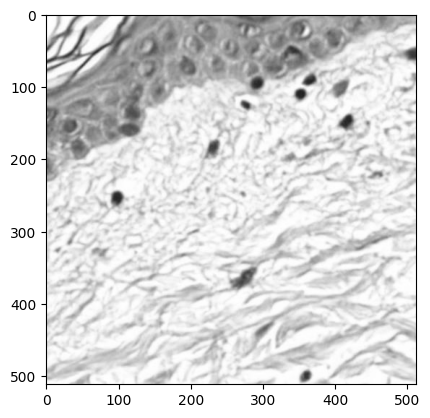

(512, 512, 3)


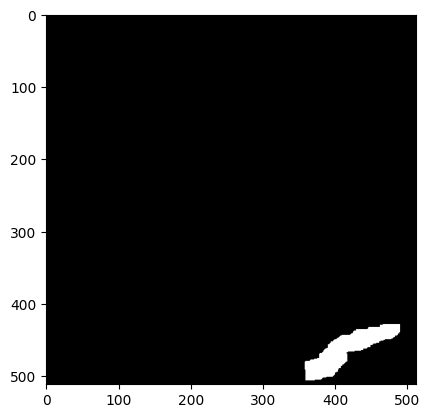

(512, 512)


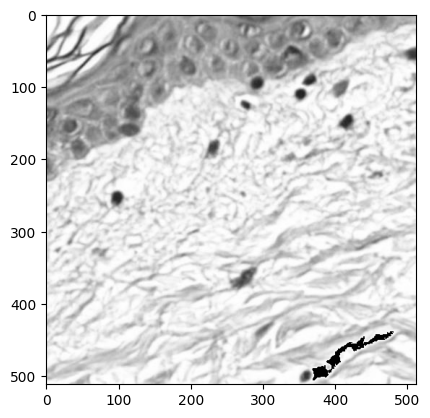

(512, 512)


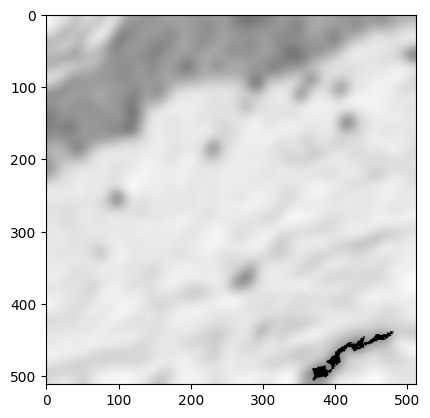

(512, 512, 3)


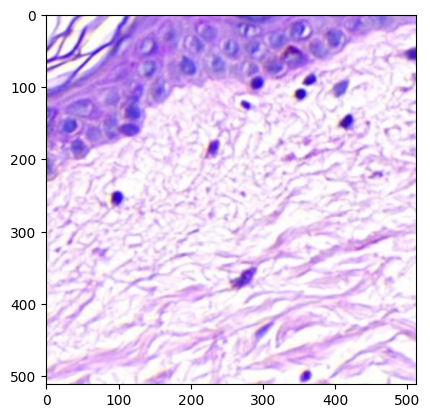

(512, 512)
(512, 512, 3)


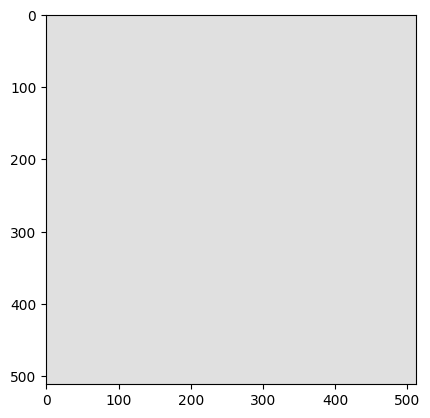

(512, 512, 3)


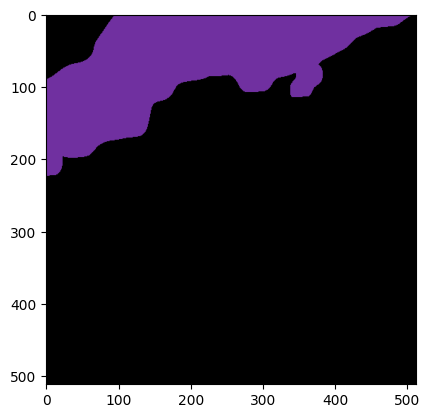

(512, 512, 3)


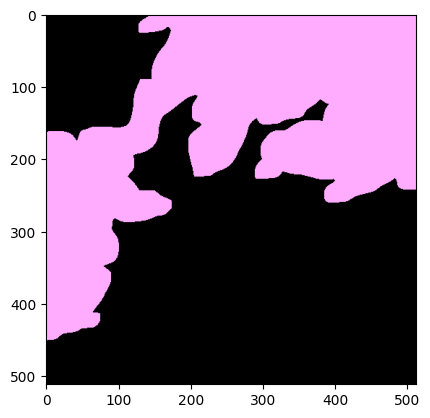

(512, 512, 3)


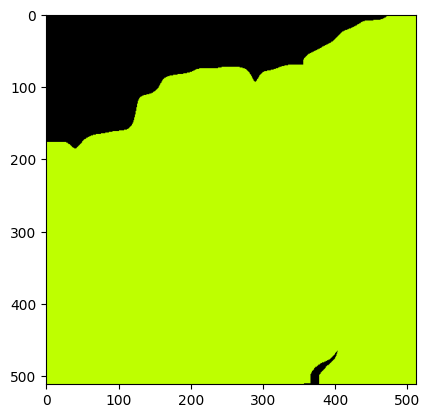

(512, 512, 3)


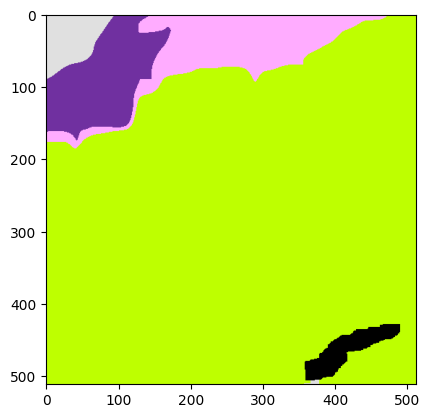

(512, 512, 3)


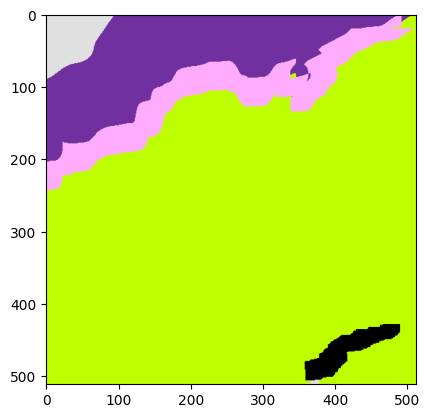

(512, 512, 3)


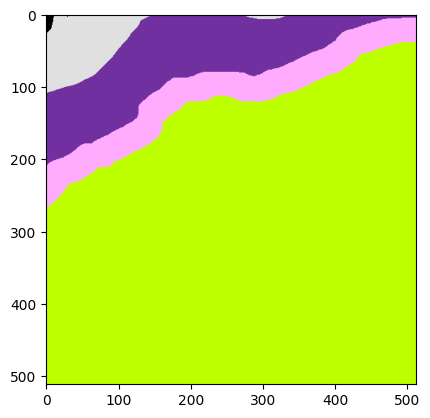

Original Size: 262144
Matching Pixels: 243739
Dice Coefficient: 0.9297904968261719


In [154]:
image_number = 98

original_image,bg_removed,bg_shaded,original_mask = removeBackground(image_number,isShow=True)
showImage(original_image)

generated_mask = generateMask(bg_removed,bg_shaded,masks,isShow=False,isSeparate=True)
showImage(generated_mask)
showImage(original_mask)

dice_coeff = calculate_dicecoeff(original_mask,generated_mask)
print(f"Dice Coefficient: {dice_coeff}")



In [112]:
dice_coeff = calculate_dicecoeff(original_mask,generated_mask)
print(dice_coeff)

Original Size: 262144
Matching Pixels: 220309
0.8404121398925781


In [115]:
def runAll():
    f = open(output_path+"dice_coeff3.txt", "w")
    f.write("Dice Coefficient Data"+"\n")
    f.close()
    for i in range(1,140,1):
        image_number = i
        original_image,bg_removed,bg_shaded,original_mask = removeBackground(image_number,isShow=False)

        generated_mask = generateMask(bg_removed,bg_shaded,masks,isShow=False,isSeparate=False)

        cv.imwrite(output_path+"/GeneratedMasks3/GeneratedMask"+str(image_number)+".jpg",generated_mask)

        dice_coeff = calculate_dicecoeff(original_mask,generated_mask)
        print("Dice Coefficient: " + str(dice_coeff))

        f = open(output_path+"dice_coeff3.txt", "a")
        f.write(str(image_number)+": " +str(dice_coeff) +"\n")
        f.close()

In [116]:
runAll()

(512, 512)
Original Size: 262144
Matching Pixels: 167709
Dice Coefficient: 0.6397590637207031
(512, 512)
Original Size: 262144
Matching Pixels: 200430
Dice Coefficient: 0.7645797729492188
(512, 512)
Original Size: 262144
Matching Pixels: 21877
Dice Coefficient: 0.08345413208007812
(512, 512)
Original Size: 262144
Matching Pixels: 28647
Dice Coefficient: 0.10927963256835938
(512, 512)
Original Size: 262144
Matching Pixels: 199057
Dice Coefficient: 0.7593421936035156
(512, 512)
Original Size: 262144
Matching Pixels: 174703
Dice Coefficient: 0.6664390563964844
(512, 512)
Original Size: 262144
Matching Pixels: 191096
Dice Coefficient: 0.728973388671875
(512, 512)
Original Size: 262144
Matching Pixels: 197810
Dice Coefficient: 0.7545852661132812
(512, 512)
Original Size: 262144
Matching Pixels: 202423
Dice Coefficient: 0.7721824645996094
(512, 512)
Original Size: 262144
Matching Pixels: 245140
Dice Coefficient: 0.9351348876953125
(512, 512)
Original Size: 262144
Matching Pixels: 215786
Dice

In [139]:
def read_coeff_from_file(file_path):
    coeff_array = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split(':')
                if len(parts) == 2:
                        coeff_array.append(float(parts[1].strip()))
                else:
                    print(f"Invalid line: '{line}'")
    return coeff_array

file_path = output_path+"dice_coeff3.txt"  
coeff_array = read_coeff_from_file(file_path)
print("Dice Coefficient array:", coeff_array)
print(np.mean(coeff_array))

Invalid line: 'Dice Coefficient Data'
Dice Coefficient array: [0.6397590637207031, 0.7645797729492188, 0.08345413208007812, 0.10927963256835938, 0.7593421936035156, 0.6664390563964844, 0.728973388671875, 0.7545852661132812, 0.7721824645996094, 0.9351348876953125, 0.8231582641601562, 0.8692550659179688, 0.8481712341308594, 0.5922698974609375, 0.866180419921875, 0.8491401672363281, 0.9155845642089844, 0.8681564331054688, 0.7774848937988281, 0.7729530334472656, 0.8208503723144531, 0.8235282897949219, 0.9297904968261719, 0.7782096862792969, 0.9257316589355469, 0.7389373779296875, 0.6589431762695312, 0.9529457092285156, 0.7703514099121094, 0.7347183227539062, 0.7881202697753906, 0.834197998046875, 0.5636405944824219, 0.73492431640625, 0.6469078063964844, 0.5932884216308594, 0.7586402893066406, 0.7764434814453125, 0.6305160522460938, 0.9132652282714844, 0.8171272277832031, 0.8920669555664062, 0.9252052307128906, 0.7708244323730469, 0.9275932312011719, 0.9214096069335938, 0.8121719360351562, 